---
layout: post  
---

Here we are designing a "tip-clipping" algorithm.

One of the strengths of using a graph-based error-correction strategy is that we have contextual awareness. Each region of the sequence being evaluated for correctness is not only being evaluated based on the information in the immediate vicinity, but also based on all of the information that has precede it and all of the information that follows.

The beginning and ends of sequences, particularly if they occur as degree 1 nodes on the assembly graph, we lose one of those two contextual directions and therefor the error-correction process is less robust.

Generally, these graph "tips" tend to harbor remaining errors after the rest of the error correction procedure has occured.

As a final graph cleaning step, we can search for all of these tips and then remove any tips that have very low evidence to support them.

Initially, we will define low evidence as anything with a single supporting read OR anything with coverage that is greater than 3 standard deviations below the median coverage of the rest of the connected component of the graph

In [1]:
import Pkg
pkgs = [
    "Eisenia",
    "Random",
    "Revise",
    "BioSequences",
    "Test",
    "LightGraphs",
    "Primes",
    "Statistics",
    "Plots"
]

for pkg in pkgs
    try
        Pkg.add(pkg)
    catch
        # tried to install an unregistered local package
    end
    eval(Meta.parse("import $pkg"))
end

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 % %Fetching: [======>                                  ]  13.6 %>                             ]  26.1 %Fetching: [=============>                           ]  32.0 %>                      ]  44.5 %                 ]  57.3 %Fetching: [=============================>           ]  70.2 %Fetching: [=============================>           ]  72.3 %Fetching: [==============================>          ]  74.7 %Fetching: [===============================>         ]  76.4 %Fetching: [================================>        ]  78.6 % %>]  98.1 %

  Resolving package versions...
┌ Info: Precompiling Eisenia [453d265d-8292-4a7b-a57c-dce3f9ae6acd]
└ @ Base loading.jl:1278
  Resolving package versions...
  Installed Adapt ─────────── v3.1.0
  Installed PlotUtils ─────── v1.0.10
  Installed JLLWrappers ───── v1.2.0
  Installed Tables ────────── v1.3.1
  Installed Tokenize ──────── v0.5.10
  Installed Missings ──────── v0.4.5
  Installed ChainRulesCore ── v0.9.27
  Installed Distances ─────── v0.10.1
  Installed OffsetArrays ──── v1.5.2
  Installed Parameters ────── v0.12.2
  Installed ProgressLogging ─ v0.1.4
  Installed StructArrays ──── v0.4.2
  Installed IntelOpenMP_jll ─ v2018.0.3+2
  Installed TerminalLoggers ─ v0.1.3
  Installed GeometryBasics ── v0.3.8
  Installed DataAPI ───────── v1.4.1
No Changes to `~/.julia/environments/v1.5/Project.toml`
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [79e6a3ab] ↑ Adapt v2.3.0 ⇒ v3.1.0
  [d360d2e6] ↑ ChainRulesCore v0.9.24 ⇒ v0.9.27
  [9a962f9c] ↑ DataAPI v1.4.0 ⇒ v1.4.1
  [b4f34e

In [5]:
function my_plot(graph::Eisenia.KmerGraph)
    graph_hash = hash(sort(graph.graph.fadjlist), hash(graph.graph.ne))
    filename = "/assets/images/$(graph_hash).svg"
    p = Eisenia.plot_graph(graph)
    Plots.savefig(p, dirname(pwd()) * filename)
    display(p)
    display("text/markdown", "![]($filename)")
end

my_plot (generic function with 1 method)

In [6]:
n_sequences = 1
seqlen = 10
sequences = [BioSequences.randdnaseq(Random.seed!(i), seqlen) for i in 1:n_sequences]

1-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 TCGTCCCAGG

In [4]:
n_observations = 100
error_rate = 0.05

Random.seed!(1)
observations = [
    Eisenia.observe(rand(sequences), error_rate = error_rate) 
        for i in 1:n_observations
]

100-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 CCTGGGACGA
 TCGTCCCAGG
 CCTGGGACGA
 CCTGGGATCGA
 CCTGGGACGA
 TCGTCCCAGG
 TCGTCCAGG
 TGTCCCAGG
 CCTGGGACGA
 CCTGGGACGA
 CCTGGGACCA
 TCGTCCCAGG
 CCTGGGACGA
 ⋮
 TCGTCCCAGCG
 TCGTCCCATG
 TCGTCCCAGG
 TCGTCCCAGG
 TCGTCCCAGG
 CCTGGGACGA
 CCTGGCGACGA
 TCGTCCCAGG
 TCGTCCCAGG
 TCACGTCCCGAGG
 CCTGGGACGA
 TCGCTCCCAGG

In [7]:
function assess_observations(graph::Eisenia.KmerGraph{KMER_TYPE}, observations, error_rate) where {KMER_TYPE}
    k = last(KMER_TYPE.parameters)
    total_edits_accepted = 0
    total_bases_evaluated = 0
    reads_processed = 0
    maximum_likelihood_observations = Vector{BioSequences.LongDNASeq}(undef, length(observations))
    for (observation_index, observation) in enumerate(observations)
        if length(observation) >= k
            optimal_path, edit_distance, relative_likelihood = Eisenia.viterbi_maximum_likelihood_path(graph, observation, error_rate)
            maximum_likelihood_observation = Eisenia.oriented_path_to_sequence(optimal_path, graph.kmers)
            maximum_likelihood_observations[observation_index] = maximum_likelihood_observation
            reads_processed += 1
            total_bases_evaluated += length(observation)
            total_edits_accepted += edit_distance
        else
            maximum_likelihood_observations[observation_index] = observation
        end
    end
    inferred_error_rate = round(total_edits_accepted / total_bases_evaluated, digits = 3)
    display("reads_processed = $(reads_processed)")
    display("total_edits_accepted = $(total_edits_accepted)")
    display("inferred_error_rate = $(inferred_error_rate)")
    if total_edits_accepted == 0
        has_converged = true
    else
        has_converged = false
    end
    return maximum_likelihood_observations, has_converged
end

assess_observations (generic function with 1 method)

In [8]:
function iterate_until_convergence(ks, observations, error_rate)
    for k in ks
        graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)
        display("k = $k")
        my_plot(graph)
        observations, has_converged = assess_observations(graph, observations, error_rate)
    end
    graph = Eisenia.KmerGraph(BioSequences.DNAMer{last(ks)}, observations)
    display("final graph")
    my_plot(graph)
    return observations
end

iterate_until_convergence (generic function with 1 method)

Here we perform error correction as we have in previous posts

"k = 3"

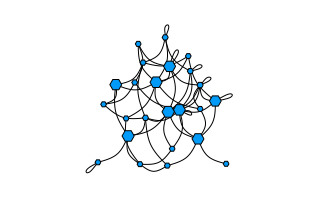

![](/assets/images/11516063661208544668.svg)

"reads_processed = 100"

"total_edits_accepted = 37"

"inferred_error_rate = 0.037"

"k = 5"

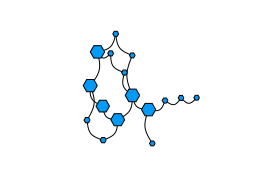

![](/assets/images/9366657123667438041.svg)

"reads_processed = 100"

"total_edits_accepted = 17"

"inferred_error_rate = 0.017"

"k = 7"

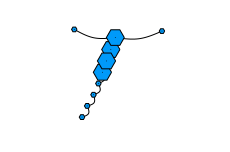

![](/assets/images/7625239065058145842.svg)

"reads_processed = 100"

"total_edits_accepted = 9"

"inferred_error_rate = 0.009"

"final graph"

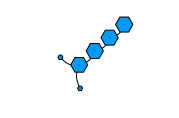

![](/assets/images/16902361047499149513.svg)

100-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 CCTGGGACGA
 TCGTCCCAGG
 CCTGGGACGA
 CCTGGGACGA
 CCTGGGACGA
 TCGTCCCAGG
 TCGTCCCAGG
 CGTCCCAGG
 CCTGGGACGA
 CCTGGGACGA
 CCTGGGACGA
 TCGTCCCAGG
 CCTGGGACGA
 ⋮
 TCGTCCCAGG
 TCGTCCCAGG
 TCGTCCCAGG
 TCGTCCCAGG
 TCGTCCCAGG
 CCTGGGACGA
 CCTGGGACGA
 TCGTCCCAGG
 TCGTCCCAGG
 TCCCAGG
 CCTGGGACGA
 TCGTCCCAGG

In [9]:
corrected_observations = iterate_until_convergence(Primes.primes(3, 7), observations, error_rate)

In [10]:
graph = Eisenia.KmerGraph(BioSequences.DNAMer{7}, corrected_observations)

Eisenia.KmerGraph{BioSequences.Mer{BioSequences.DNAAlphabet{2},7}}({6, 5} undirected simple Int64 graph, Dict{LightGraphs.SimpleGraphs.SimpleEdge{Int64},Array{Eisenia.EdgeEvidence,1}}(Edge 3 => 6 => [Eisenia.EdgeEvidence(68, 1)],Edge 2 => 4 => [Eisenia.EdgeEvidence(1, 2), Eisenia.EdgeEvidence(2, 2), Eisenia.EdgeEvidence(3, 2), Eisenia.EdgeEvidence(4, 2), Eisenia.EdgeEvidence(5, 2), Eisenia.EdgeEvidence(6, 2), Eisenia.EdgeEvidence(7, 2), Eisenia.EdgeEvidence(8, 1), Eisenia.EdgeEvidence(9, 2), Eisenia.EdgeEvidence(10, 2)  …  Eisenia.EdgeEvidence(90, 2), Eisenia.EdgeEvidence(91, 2), Eisenia.EdgeEvidence(92, 2), Eisenia.EdgeEvidence(93, 2), Eisenia.EdgeEvidence(94, 2), Eisenia.EdgeEvidence(95, 2), Eisenia.EdgeEvidence(96, 2), Eisenia.EdgeEvidence(97, 2), Eisenia.EdgeEvidence(99, 2), Eisenia.EdgeEvidence(100, 2)],Edge 1 => 4 => [Eisenia.EdgeEvidence(1, 1), Eisenia.EdgeEvidence(2, 3), Eisenia.EdgeEvidence(3, 1), Eisenia.EdgeEvidence(4, 1), Eisenia.EdgeEvidence(5, 1), Eisenia.EdgeEvidence(6, 

In this final graph produced after the viterbi error correction procedure, we can see the 4 core large nodes and the 2 outlier tips.

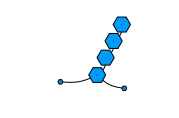

![](/assets/images/16902361047499149513.svg)

In [11]:
my_plot(graph)

While there aren't any other clusters to worry about, we can reliably pull out clusters of connected nodes by searching for connected components

In [12]:
connected_components = LightGraphs.connected_components(graph.graph)

1-element Array{Array{Int64,1},1}:
 [1, 2, 3, 4, 5, 6]

In [13]:
connected_component = first(connected_components)

6-element Array{Int64,1}:
 1
 2
 3
 4
 5
 6

With the connected component extracted, we can review the coverage for each of the nodes

In [14]:
coverage = graph.counts[connected_component]

6-element Array{Int64,1}:
 99
 98
  1
 98
  1
 96

We can see above that core nodes have coverage ~100 and an overall median coverage of 97, very close to the 100 simulated reads of coverage we initiated this experiment with

In [16]:
median_coverage = Statistics.median(coverage)

97.0

Because there are so few nodes, the 2 outliers are 1/3 of the total data points in our coverage evaluation, making the standard deviation > 50% of the median coverage

In [17]:
coverage_std = Statistics.std(coverage)

49.97099158511866

While in larger graphs with more confident nodes relative to erroneous tips, I imagine we'd be able to do more probabilistic tip clipping by removing any nodes with < 3 standard deviations of coverage, we will also accept any tips with 1 x coverage which is sufficient to flag the outlier nodes in this example for removal

In [19]:
vertices_to_keep = Int[]
for vertex in connected_component
    
    this_degree = LightGraphs.degree(graph.graph, vertex)
    
    this_coverage = graph.counts[vertex]
    magnitude_below_median = median_coverage - graph.counts[vertex]
    
    is_low_coverage = (this_coverage == 1) || (magnitude_below_median >= 3*coverage_std)
    
    if (this_degree == 1) && is_low_coverage
        @show vertex
    else
        push!(vertices_to_keep, vertex)
    end
end

vertex = 3
vertex = 5


Above we see that we've flagged the two outlier low coverage nodes for removal while the rest have been added to a "vertices_to_keep" vector that will be used to rebuild a graph below

In [21]:
KmerType = first(typeof(graph).parameters)
new_graph = Eisenia.KmerGraph(KmerType, observations, graph.kmers[vertices_to_keep], graph.counts[vertices_to_keep])

Eisenia.KmerGraph{BioSequences.Mer{BioSequences.DNAAlphabet{2},7}}({4, 3} undirected simple Int64 graph, Dict{LightGraphs.SimpleGraphs.SimpleEdge{Int64},Array{Eisenia.EdgeEvidence,1}}(Edge 2 => 4 => [Eisenia.EdgeEvidence(1, 3), Eisenia.EdgeEvidence(2, 1), Eisenia.EdgeEvidence(3, 3), Eisenia.EdgeEvidence(5, 3), Eisenia.EdgeEvidence(6, 1), Eisenia.EdgeEvidence(9, 3), Eisenia.EdgeEvidence(10, 3), Eisenia.EdgeEvidence(12, 1), Eisenia.EdgeEvidence(13, 3), Eisenia.EdgeEvidence(15, 3)  …  Eisenia.EdgeEvidence(88, 1), Eisenia.EdgeEvidence(89, 1), Eisenia.EdgeEvidence(90, 1), Eisenia.EdgeEvidence(91, 1), Eisenia.EdgeEvidence(92, 1), Eisenia.EdgeEvidence(93, 1), Eisenia.EdgeEvidence(94, 3), Eisenia.EdgeEvidence(96, 1), Eisenia.EdgeEvidence(97, 1), Eisenia.EdgeEvidence(99, 3)],Edge 1 => 3 => [Eisenia.EdgeEvidence(1, 1), Eisenia.EdgeEvidence(2, 3), Eisenia.EdgeEvidence(3, 1), Eisenia.EdgeEvidence(5, 1), Eisenia.EdgeEvidence(6, 3), Eisenia.EdgeEvidence(8, 2), Eisenia.EdgeEvidence(9, 1), Eisenia.Edg

And here we see that we've rebuild a clean graph with only the core structure remaining!

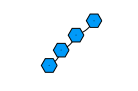

In [23]:
Eisenia.plot_graph(new_graph)

Now, we'll pull out the connected component and walk the graph to resolve the primary path

In [24]:
connected_components = LightGraphs.connected_components(new_graph.graph)

1-element Array{Array{Int64,1},1}:
 [1, 2, 3, 4]

In [25]:
connected_component = first(connected_components)

4-element Array{Int64,1}:
 1
 2
 3
 4

In [32]:
function take_a_walk(graph, connected_component)
    max_count = maximum(graph.counts[connected_component])
    max_count_indices = findall(count -> count == max_count, graph.counts[connected_component])
    initial_node_index = rand(max_count_indices)
    initial_node = connected_component[initial_node_index]
    outgoing_edge_probabilities, incoming_edge_probabilities = Eisenia.determine_edge_probabilities(graph)
    forward_walk = take_a_walk(graph, [Eisenia.OrientedKmer(index = initial_node, orientation = true)], outgoing_edge_probabilities, incoming_edge_probabilities)
    reverse_walk = take_a_walk(graph, [Eisenia.OrientedKmer(index = initial_node, orientation = false)], outgoing_edge_probabilities, incoming_edge_probabilities)
    reversed_reverse_walk = reverse!(
        [
            Eisenia.OrientedKmer(index = oriented_kmer.index, orientation = oriented_kmer.orientation)
            for oriented_kmer in reverse_walk[2:end]
        ]
        )
    full_path = [reversed_reverse_walk..., forward_walk...]
    @show full_path
end

function take_a_walk(graph, path::Vector{Eisenia.OrientedKmer}, outgoing_edge_probabilities, incoming_edge_probabilities)
    done = false
    while !done
        maximum_path_likelihood = 0.0
        maximum_likelihood_path = Vector{Eisenia.OrientedKmer}()
        for neighbor in LightGraphs.neighbors(graph.graph, last(path).index)
            this_path = [last(path).index, neighbor]
            this_oriented_path, this_path_likelihood = 
                Eisenia.assess_path(this_path,
                    graph.kmers,
                    graph.counts,
                    last(path).orientation,
                    outgoing_edge_probabilities,
                    incoming_edge_probabilities)
            if this_path_likelihood > maximum_path_likelihood
                maximum_path_likelihood = this_path_likelihood
                maximum_likelihood_path = this_oriented_path
            end
        end
        if isempty(maximum_likelihood_path) && (maximum_path_likelihood == 0.0)
            done = true
        else
            append!(path, maximum_likelihood_path[2:end])
        end
    end
    return path
end

take_a_walk (generic function with 2 methods)

In [37]:
function is_equivalent(a, b)
    a == b || a == BioSequences.reverse_complement(b)
end

is_equivalent (generic function with 1 method)

Here we've pulled out the primary path

In [38]:
maximum_likelihood_walk = take_a_walk(new_graph, connected_component)

full_path = Eisenia.OrientedKmer[Eisenia.OrientedKmer(1, true), Eisenia.OrientedKmer(3, true), Eisenia.OrientedKmer(2, false), Eisenia.OrientedKmer(4, true)]


4-element Array{Eisenia.OrientedKmer,1}:
 Eisenia.OrientedKmer(1, true)
 Eisenia.OrientedKmer(3, true)
 Eisenia.OrientedKmer(2, false)
 Eisenia.OrientedKmer(4, true)

In [40]:
resolved_sequence = Eisenia.oriented_path_to_sequence(maximum_likelihood_walk, graph.kmers)

10nt DNA Sequence:
CCTGGGACGC

In [41]:
original_sequence = first(sequences)

10nt DNA Sequence:
TCGTCCCAGG

In [42]:
is_equivalent(resolved_sequence, original_sequence)

false

Evaluate why these don't match!!